In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession \
    .builder \
    .appName("Learning Spark") \
    .getOrCreate()

In [2]:
claims = spark.read.json("harvester/claims/*jsonl")

In [3]:
df = spark.read.json("harvester/ct/bigharvey-CT*-rv0_0_9.jsonl.gz")

In [4]:
df.printSchema()

root
 |-- crawler: string (nullable = true)
 |-- identifier: string (nullable = true)
 |-- jobposting: struct (nullable = true)
 |    |-- @context: string (nullable = true)
 |    |-- @type: string (nullable = true)
 |    |-- baseSalary: struct (nullable = true)
 |    |    |-- @context: string (nullable = true)
 |    |    |-- @type: string (nullable = true)
 |    |    |-- currency: string (nullable = true)
 |    |    |-- value: struct (nullable = true)
 |    |    |    |-- @context: string (nullable = true)
 |    |    |    |-- @type: string (nullable = true)
 |    |    |    |-- unitText: string (nullable = true)
 |    |    |    |-- value: string (nullable = true)
 |    |-- datePosted: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- directApply: boolean (nullable = true)
 |    |-- employmentType: string (nullable = true)
 |    |-- hiringOrganization: struct (nullable = true)
 |    |    |-- @context: string (nullable = true)
 |    |    |-- @type: string (

### Registros Totales

In [5]:
df.count()

3207336

### Registros Únicos por Identifier (asume único por jobad)

In [6]:
df.dropDuplicates(["identifier"]).count()

236502

In [7]:
df.select("identifier").distinct().count()

236502

### Registros scrapeados por día

In [10]:
day_count = df.select(
    "identifier",
    F.year("scraped_at").alias('year'), 
    F.month("scraped_at").alias('month'), 
    F.dayofmonth("scraped_at").alias('day')
).groupby("month", "day").count().orderBy(['month', 'day'])
print(day_count.describe("count").show())
day_count.show(day_count.count())

+-------+------------------+
|summary|             count|
+-------+------------------+
|  count|                27|
|   mean|118790.22222222222|
| stddev| 1805.439118402058|
|    min|            114418|
|    max|            122478|
+-------+------------------+

None
+-----+---+------+
|month|day| count|
+-----+---+------+
|    6| 24|122478|
|    6| 25|120437|
|    6| 26|116018|
|    6| 27|118909|
|    6| 28|120633|
|    6| 29|121092|
|    6| 30|118072|
|    7|  1|118814|
|    7|  2|117764|
|    7|  3|116637|
|    7|  4|117580|
|    7|  5|117571|
|    7|  6|118062|
|    7|  7|119315|
|    7|  8|119143|
|    7|  9|118044|
|    7| 10|114418|
|    7| 11|116580|
|    7| 12|118589|
|    7| 13|119663|
|    7| 14|120504|
|    7| 15|119897|
|    7| 17|117390|
|    7| 18|118020|
|    7| 20|120057|
|    7| 21|120817|
|    7| 22|120832|
+-----+---+------+



<Axes: >

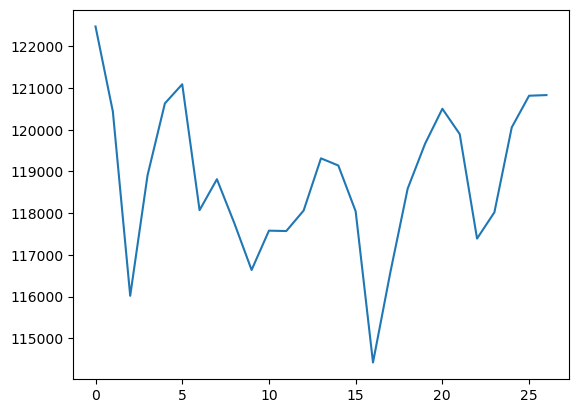

In [11]:
day_counts_p = day_count.toPandas()
day_counts_p["count"].plot()

(array([1., 1., 2., 3., 5., 4., 4., 5., 1., 1.]),
 array([114418., 115224., 116030., 116836., 117642., 118448., 119254.,
        120060., 120866., 121672., 122478.]),
 <BarContainer object of 10 artists>)

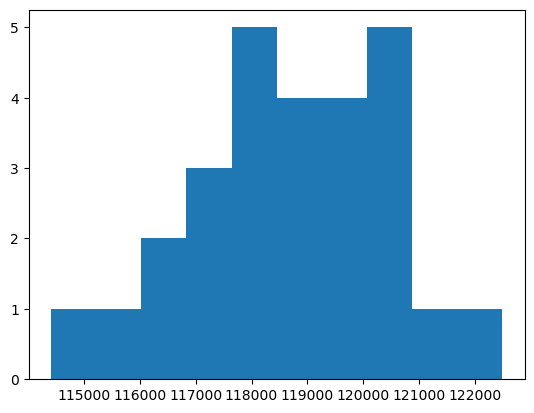

In [12]:
plt.hist(day_counts_p["count"], bins=10)

In [13]:
claims_p = claims.where("version = '0.0.2'")\
    .where(claims.url.startswith("https://mx.computrabajo"))\
    .sort("scraped_at")\
    .withColumn("num_claim", claims["claim"].cast("int"))\
    .select(    
        F.month("scraped_at").alias('month'), 
        F.dayofmonth("scraped_at").alias('day'),
        "num_claim"
    ).toPandas()

In [14]:
claims_p

,month,day,num_claim
0,6,18,131795
1,6,18,131675
2,6,19,131743
3,6,19,131562
4,6,19,131125
...,...,...,...
206,7,23,132172
207,7,23,131685
208,7,23,130979
209,7,23,130787


,month,day,num_claim,count,pct
0,6,24,134737,122478,0.909015
1,6,24,134455,122478,0.910922
2,6,24,133879,122478,0.914841
3,6,24,133350,122478,0.918470
4,6,24,133246,122478,0.919187
...,...,...,...,...,...
156,7,22,133216,120832,0.907038
157,7,22,132770,120832,0.910085
158,7,22,132287,120832,0.913408
159,7,22,132258,120832,0.913608


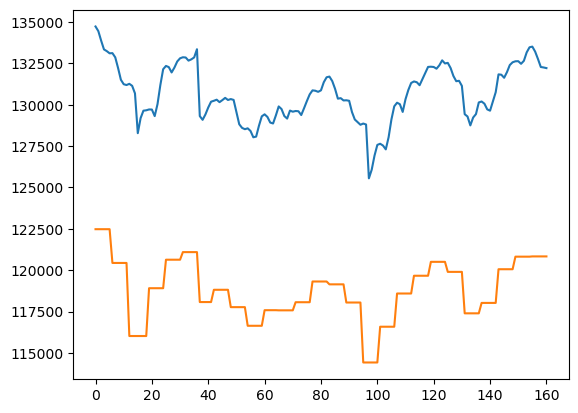

In [15]:
claims_and_counts = claims_p.merge(day_counts_p)
claims_and_counts['pct'] = claims_and_counts['count'] / claims_and_counts.num_claim 
plt.plot(claims_and_counts.num_claim)
plt.plot(claims_and_counts["count"])
claims_and_counts

count    161.000000
mean       0.908980
std        0.006061
min        0.883819
25%        0.906586
50%        0.910332
75%        0.912170
max        0.920099
Name: pct, dtype: float64

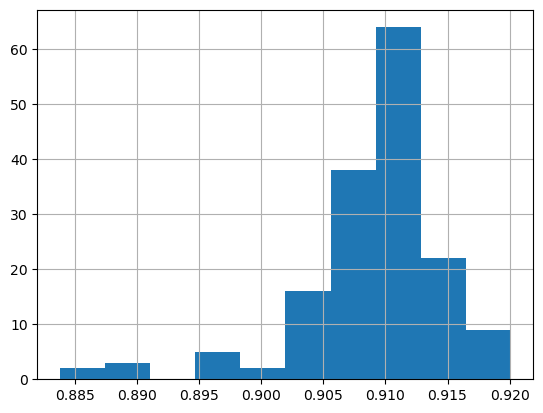

In [16]:
claims_and_counts.pct.hist()
claims_and_counts.pct.describe()

## Ubicación

## Stats

In [ ]:
stats_df = spark.read.json("harvester/ct/*stats.json")
stats_df.printSchema()

In [ ]:
stats_df.toPandas().plot("start_time", "downloader/response_status_count/200")

In [ ]:
df.rdd.mapPartitionsWithIndex(lambda x, it: [(x, sum(1 for _ in it))]).collect()